In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pandas as pd
import numpy as np

import mne
from mne.minimum_norm import apply_inverse, make_inverse_operator
from mne.decoding import GeneralizingEstimator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.decomposition import PCA

from scipy.stats import spearmanr

In [42]:
#set subject ID
sub_id = "A0305" # A0270

# Set relative folder path to data
folder = './sub_data/'
raw = folder + f'{sub_id}_shepard-epo-lp20.fif'

In [43]:
fif = mne.read_epochs(raw);

print(np.shape(fif.get_data(picks=['meg'])))

Reading C:\Users\isaac\Code\surp\sub_data\A0305_shepard-epo-lp20.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Adding metadata with 16 columns
7624 matching events found
No baseline correction applied
0 projection items activated
(7624, 208, 161)


In [28]:
fif.info

Measurement date,"May 26, 2019 10:00:15 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,3122 points
Good channels,"208 Magnetometers, 16 Reference Magnetometers, 32 misc, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,1.00 Hz
Lowpass,20.00 Hz


In [44]:
metadata = fif.metadata
stim_features = metadata[["freq", "condition", "trial_type"]].to_numpy()

pure = stim_features[:,1] == 'pure'
complx = stim_features[:,1] == 'partial'
ambiguous = stim_features[:,1] == 'shepard'

sub_data = fif.get_data(picks=['meg'])
freqs = stim_features[:, 0]

In [45]:
def get_perf_timecourse(X, y, decoder, perf_metric, n_splits=5):
    classifying = len(np.unique(y)) <= 2

    n_trials, n_channels, n_times = X.shape

    scores = np.zeros(n_times)
    pvalues = np.zeros(n_times)

    kf = KFold(n_splits, shuffle=True)
    split = lambda X, y: kf.split(X)

    if classifying:
        kf = StratifiedKFold(n_splits, shuffle=True)
        # Account for the fact that StratifiedKFold takes 2 arguments to split
        split = lambda X, y: kf.split(X, y)

    max_acc = 0

    for t in range(n_times):
        t_scores = []
        t_pvalues = []

        for train_indices, test_indices in split(X, y):
            decoder = decoder.fit(X[train_indices, :, t], y[train_indices])
            y_pred = decoder.predict(X[test_indices, :, t])

            if len(np.unique(y_pred)) > 1:
                score = perf_metric(y_pred, y[test_indices])
                acc = decoder.score(X[train_indices, :, t], y[train_indices])

                # if acc > max_acc:
                #     max_acc = acc
                #     print(acc)

                if classifying:
                    t_scores.append(score)
                    t_pvalues.append(0)
                else:
                    t_scores.append(score.statistic)
                    t_pvalues.append(score.pvalue)

        scores[t] = sum(t_scores) / len(t_scores)
        pvalues[t] = max(t_pvalues)

    return scores, pvalues

def get_time_generalization(X, y, decoder_inst, perf_metric, n_splits=5):
    n_trials, n_channels, n_times = X.shape

    gen_scores = np.zeros((n_times, n_times))
    gen_pvalues = np.zeros((n_times, n_times))

    kf = KFold(n_splits)

    for t1 in range(n_times):
        for t2 in range(n_times):
            t1t2_scores = []
            t1t2_pvalues = []

            for train_indices, test_indices in kf.split(X):
                decoder = decoder_inst()
                decoder = decoder.fit(X[train_indices, :, t1], y[train_indices])
                y_pred = decoder.predict(X[test_indices, :, t2])

                score = spearmanr(y_pred, y[test_indices])

                t1t2_scores.append(score.statistic)
                t1t2_pvalues.append(score.pvalue)

            gen_scores[t1, t2] = sum(t1t2_scores) / len(t1t2_scores)
            gen_pvalues[t1, t2] = sum(t1t2_pvalues) / len(t1t2_pvalues)

    return gen_scores, gen_pvalues

In [8]:
evoked_pure = fif[pure].average()
evoked_complx = fif[complx].average()
evoked_ambiguous = fif[ambiguous].average()

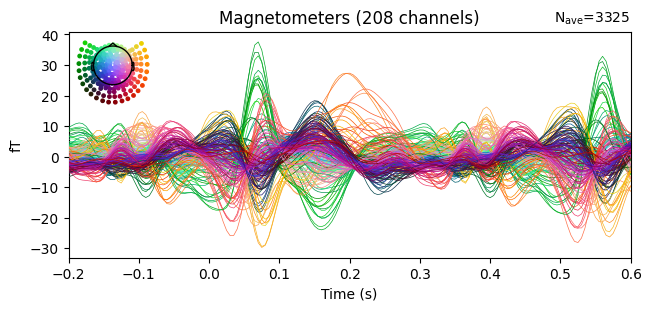

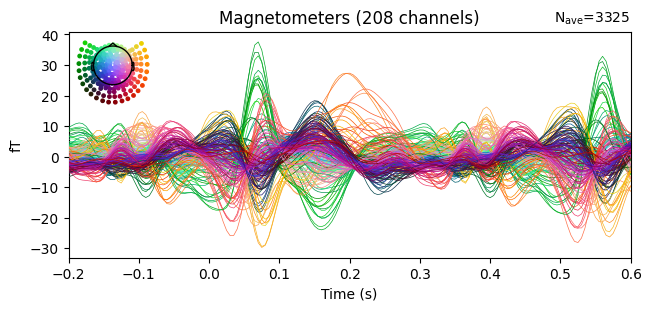

In [8]:
evoked_ambiguous.plot()

In [46]:
ridge_decoder = make_pipeline(
    StandardScaler(),
    Ridge()
)

scores_pure, _ = get_perf_timecourse(sub_data[pure], freqs[pure], ridge_decoder, spearmanr)
scores_complx, _ = get_perf_timecourse(sub_data[complx], freqs[complx], ridge_decoder, spearmanr)
scores_ambiguous, _ = get_perf_timecourse(sub_data[ambiguous], freqs[ambiguous], ridge_decoder, spearmanr)

Text(0, 0.5, 'Spearman correlation')

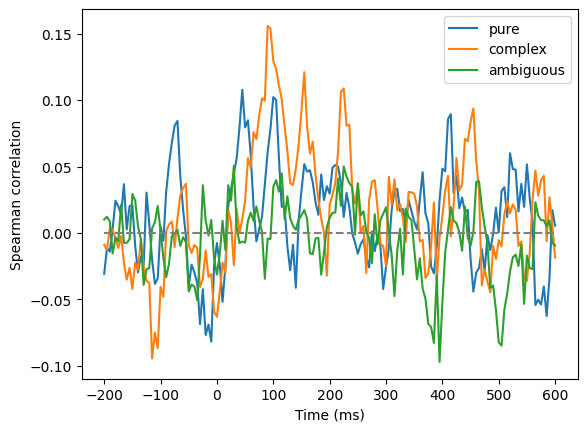

In [47]:
t = np.linspace(-200, 600, len(scores_pure))
plt.plot(t, scores_pure, label="pure")
plt.plot(t, scores_complx, label="complex")
plt.plot(t, scores_ambiguous, label="ambiguous")
plt.plot(t, np.zeros_like(t), linestyle="--", color="gray")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Spearman correlation")

In [48]:
decoder = make_pipeline(
    StandardScaler(),
    Ridge()
)

spearman_scorer = make_scorer(spearmanr, greater_is_better=True)
time_gen = GeneralizingEstimator(decoder, scoring=spearman_scorer, n_jobs=None)
time_gen.fit(X=sub_data[pure], y=freqs[pure])
output = time_gen.score(X=sub_data[pure], y=freqs[pure])

first_elem = lambda tup: tup[0]
first_elem_vectorized = np.vectorize(first_elem)
scores = first_elem_vectorized(output)

100%|██████████████████████████████████████████████| Fitting GeneralizingEstimator : 161/161 [00:04<00:00,   32.70it/s]
100%|██████████████████████████████████████████| Scoring GeneralizingEstimator : 25921/25921 [17:41<00:00,   24.42it/s]


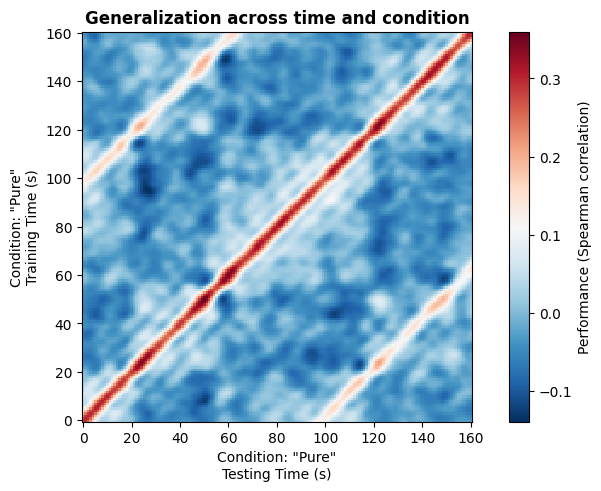

In [49]:
fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    scores,
    cmap="RdBu_r",
    origin="lower"
)
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Condition: "Pure"\nTesting Time (s)',
)
ax.set_ylabel('Condition: "Pure"\nTraining Time (s)')
ax.set_title("Generalization across time and condition", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Spearman correlation)")
plt.show()

In [50]:
import warnings
warnings.filterwarnings('ignore')

logistic_decoder = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

features_pc = stim_features[pure | complx,1] == 'pure'
input_pc = sub_data[pure | complx]
score_pc, _ = get_perf_timecourse(input_pc, features_pc, logistic_decoder, roc_auc_score)

features_pa = stim_features[pure | ambiguous,1] == 'pure'
input_pa = sub_data[pure | ambiguous]
score_pa, _ = get_perf_timecourse(input_pa, features_pa, logistic_decoder, roc_auc_score)

features_ca = stim_features[complx | ambiguous,1] == 'partial'
input_ca = sub_data[complx | ambiguous]
score_ca, _ = get_perf_timecourse(input_ca, features_ca, logistic_decoder, roc_auc_score)

(0.0, 1.0)

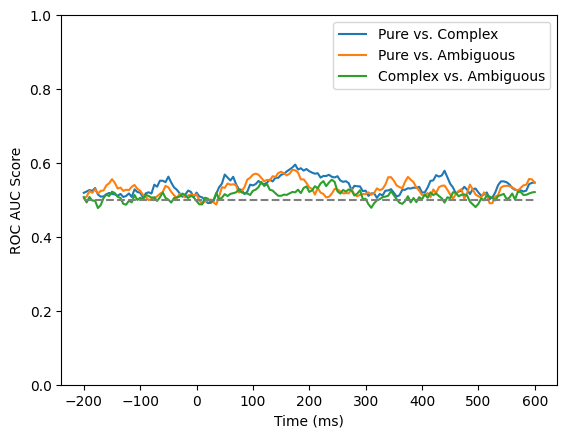

In [51]:
plt.plot(t, score_pc, label="Pure vs. Complex")
plt.plot(t, score_pa, label="Pure vs. Ambiguous")
plt.plot(t, score_ca, label="Complex vs. Ambiguous")
plt.plot(t, 0.5 * np.ones_like(t), linestyle="--", color="gray")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("ROC AUC Score")
plt.ylim([0,1])

In [ ]:
t0 = 40

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

kf = StratifiedKFold(5, shuffle=True)
X = input_pc[:,:,t0]
y = features_pc

for train, test in kf.split(X, y):
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    s = roc_auc_score(y_pred, y_test)
    print("AUC:", s)

Text(0.5, 1.0, 't=35.0ms')

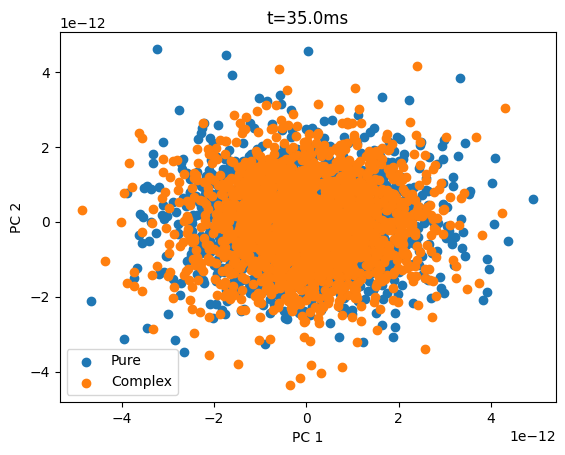

In [40]:
t0 = 47

pca = PCA(n_components=2, svd_solver='full')
transformed = pca.fit_transform(input_pc[:,:,t0])

transformed_pure = transformed[features_pc]
transformed_complx = transformed[~features_pc]

plt.scatter(transformed_pure[:,0], transformed_pure[:,1], label="Pure")
plt.scatter(transformed_complx[:,0], transformed_complx[:,1], label="Complex")
plt.legend()
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title(f"t={t[t0]}ms")

In [18]:
c = 0
loadings = pca.components_[c].copy()
n_top = 3
top_loadings = []

for i in range(n_top):
    max_idx = np.argmax(loadings)
    top_loadings.append((max_idx, loadings[max_idx]))
    loadings[max_idx] = 0
    
top_loadings

[(137, 0.20615029457880427),
 (121, 0.1937262323574115),
 (136, 0.16945149240978483)]

In [38]:
time_gen = GeneralizingEstimator(logistic_decoder, scoring="roc_auc", n_jobs=None)
time_gen.fit(X=input_pc, y=features_pc)
scores_gen_pc = time_gen.score(X=input_pc, y=features_pc)

100%|██████████████████████████████████████████████| Fitting GeneralizingEstimator : 161/161 [00:36<00:00,    4.40it/s]
100%|██████████████████████████████████████████| Scoring GeneralizingEstimator : 25921/25921 [14:39<00:00,   29.47it/s]


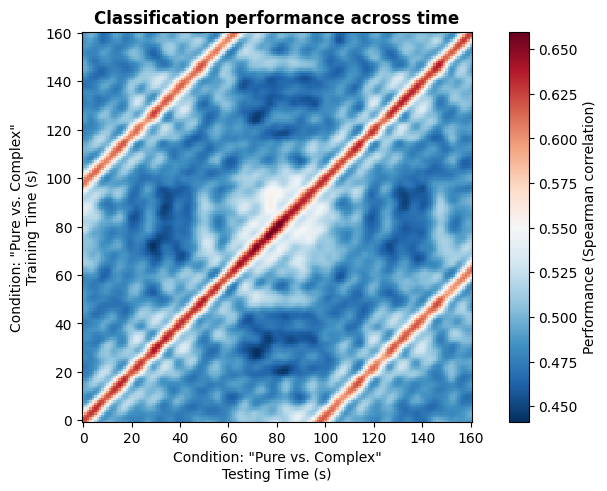

In [39]:
fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    scores_gen_pc,
    cmap="RdBu_r",
    origin="lower"
)
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Condition: "Pure vs. Complex"\nTesting Time (s)',
)
ax.set_ylabel('Condition: "Pure vs. Complex"\nTraining Time (s)')
ax.set_title("Classification performance across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Spearman correlation)")
plt.show()